In [1]:
#https://github.com/matplotlib/mplfinance/blob/master/examples/addplot.ipynb
from xlib.astock import AStock
import talib as ta
import numpy as np 
import pandas as pd
import mplfinance as mpf


def getdata(ts_code,df_cal,start_date,end_date):
    data=AStock.getStockDailyPriceByCode(ts_code,'tushare')
    if not df_cal.empty:
        data=pd.merge(df_cal,data,on=['trade_date'],how='outer', validate="one_to_many")
    data=data[data['trade_date']>=start_date]
    data=data[data['trade_date']<=end_date]
    data['score']=0
    data['ts_code']=ts_code
    data=data.fillna(method='ffill')        
    data['date'] = data['trade_date'] 
    data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y%m%d')
    data=data.set_index('trade_date')   
    data["macd"], data["macd_signal"], data["macd_hist"] = ta.MACD(data['close'])
    data['macd_hist_1']= data['macd_hist'].shift(1)
    data['gold']=data.apply(lambda x: 1 if x['macd_hist_1']<=0 and x['macd_hist']>0   else 0, axis = 1)
    data['death']=data.apply(lambda x: 1 if x['macd_hist_1']>=0 and x['macd_hist']<0   else 0, axis = 1)
    data['high_signal']=np.nan
    data['low_signal']=np.nan

    max_value=0
    min_value=9999
    max_idx=0
    min_idx=0
    last_max=0
    last_min=9999
    data.sort_index()
    for index, row in data.iterrows():   
        if row['close']>max_value:
            max_value=row['close']
            max_idx=index

        elif row['close']<min_value:
            min_value=row['close']
            min_idx=index

        elif row['gold']==1 or row['death']==1:
            data.at[max_idx,'high_signal']=max_value*1.1
            data.at[min_idx,'low_signal']=min_value*0.9
            max_value=0
            min_value=9999      


    #清理连续重复的点，在一个循环里也可以搞定，单开一个循环逻辑更清晰
    flag="none"
    high_value=0
    high_index=0
    low_value=9999
    low_index=0
    for index, row in data.iterrows():
        if  row['high_signal']>0 and row['low_signal']>0:
            data.at[index,'high_signal']=np.nan
            data.at[index,'low_signal']=np.nan

        if row['high_signal']>0 or row['low_signal']>0:
            if(flag=="none"):
                if not pd.isna(row['high_signal']):
                    flag="high"
                    high_value=row['close']
                    high_index=index
                else:
                    flag="low"
                    low_value=row['close']
                    low_index=index
            elif(flag=="high"):
                #如果上一个标记是high，且这个标记还是high
                if row['high_signal']>0:
                    #如果现在的收盘价比上一个高点还高，那么清除掉上一个标记
                    if(row['close']>high_value):
                        data.at[high_index,'high_signal']=np.nan
                        high_value=row['high_signal']
                        high_index=index
                    else:
                        data.at[index,'high_signal']=np.nan
                else:
                    flag="low"
                    low_value=row['low_signal'] 
                    low_index=index


            elif(flag=="low"):
                #如果上一个标记是low，且这个标记还是low
                if not pd.isna(row['low_signal']):
                    #如果现在的收盘价比上一个低点还低，那么清除掉上一个标记
                    if(row['close']<low_value):
                        data.at[low_index,'low_signal']=np.nan
                        low_value=row['low_signal']
                        low_index=index

                    else:
                        data.at[index,'low_signal']=np.nan
                else:
                    flag="high"
                    high_value=row['high_signal'] 
                    high_index=index        

            else:
                pass
    return data



In [2]:
def wave_signal(df,date,draw=True):
    end_date = pd.to_datetime(date, format='%Y%m%d')
    df2=df.loc[:end_date]
    df2=df2.dropna(subset=['close'])
    now=df2.iloc[-1]
    signal=df2.copy()[(df2.high_signal>0)|(df2.low_signal>0)]
    signal['signal']=signal.apply(lambda x:'high' if x['high_signal']>0 else 'low',axis=1)
    alines=[]
    now_close=now['close']

    #起点
    start=df2.loc[:df2['close'].idxmax()]['close'].idxmin()
    alines.append((start,df2.loc[start]['close']))

    #浪1
    for idx,row in signal.iterrows():
        if idx<start:
            pass
        elif(row['signal']=='high'):
            w1=idx
            break


    #浪5
    w5=df2['close'].idxmax() 
    #新高
    if(df2['close'].max()==now_close) and len(signal)>2:
        return 1;
    
 
    #浪3
    signal3=signal.copy()
    signal3=signal3[start:w5]
    signal3=signal3.sort_values(by='close',ascending=False)
    w3=None
    for idx,row in signal3[1:].iterrows():
        #3不最短
        if(len(df2[start:idx]) >len(df2[idx:w5])):
            w3=idx
            break
    if(w3==None):
        #print("5浪未成")
        return 0
        
    #浪2
    signal2=signal.copy()
    signal2=signal2[w1:w3]
    signal2=signal2.sort_values(by='close',ascending=True)
    w2=None
    for idx,row in signal2.iterrows():
        #2不破1
        if(row['close']<df2.loc[w1]['close']):
            w2=idx
            break
    if(w2==None):
        #print("5浪未成")     
        return 0
     
    
    #浪4
    signal4=signal.copy()
    signal4=signal4[w3:w5]
    signal4=signal4.sort_values(by='close',ascending=True)
    w4=None
    for idx,row in signal4.iterrows():
        #4不进1
        if(row['close']>df2.loc[w1]['close']):
            w4=idx
            break
    if(w4==None):
        #print("5浪未成")  
        return 0


    start_close=data.loc[start]['close']
    now_close=data.iloc[-1]['close']
    min_close=data.loc[w5:]['close'].min()
    min_idx=data.loc[w5:]['close'].min()
    #跌到位了
    if(min_close<data.loc[w5]['close']*(1-0.618)):
        #涨回去了
        if now_close>data.loc[w5]['close']*(1-0.618) and data.loc[min_idx:]['close'].max()==now_close:
            return 1
        else:
            return 0
    else:
        return 0

data=getdata('002624.sz',pd.DataFrame(),'20180101','20200901')
wave_signal(data,'20210108')

0

In [3]:
from xlib.mysql import mysql
import tushare as ts
db="tushare"
start_date='20100101'
end_date='20220415'
df_cal=mysql.selectToDf("select cal_date as trade_date from astock_trade_cal where is_open=1",db)
basic=mysql.selectToDf("select ts_code,industry from astock_basic",db)

pro = ts.pro_api()
df_code = pro.index_weight(index_code='000300.SH', start_date=start_date, end_date=end_date)
df_code.drop_duplicates(subset=['con_code'],keep='first',inplace=True)
 
df_all=[]
df_mean_all=[]
df_code=df_code['con_code'].to_list()


for ts_code in df_code:
    df=getdata(ts_code,df_cal,start_date,end_date)
    for date in df.index.tolist():
        try:
            score=wave_signal(df,date)
            df.at[date,'score']=score
            if score>0:
                pass
        except:
            pass
    
    
    df_all.append(df)
    print(ts_code)
df_all=pd.concat(df_all)
df_all.to_csv("./xlib/cache/fin43.csv")
df_all

603195.SH
003816.SZ
300782.SZ
601138.SH
600989.SH
601698.SH
300750.SZ
601916.SH
002938.SZ
601319.SH
603259.SH
601236.SH
300896.SZ
601865.SH
601066.SH
300759.SZ
300760.SZ
688111.SH
601990.SH
603486.SH
002916.SZ
603392.SH
600025.SH
603659.SH
603087.SH
300677.SZ
603882.SH
603260.SH
001979.SZ
300676.SZ
603233.SH
601155.SH
300628.SZ
601108.SH
300498.SZ
300595.SZ
300601.SZ
603501.SH
002841.SZ
603833.SH
603517.SH
601881.SH
300408.SZ
300413.SZ
300558.SZ
300450.SZ
603019.SH
603658.SH
002812.SZ
603939.SH
603338.SH
601966.SH
603799.SH
300433.SZ
002821.SZ
603160.SH
603986.SH
601985.SH
300529.SZ
002791.SZ
601021.SH
603369.SH
603899.SH
000333.SZ
601808.SH
601939.SH
002179.SZ
601169.SH
603806.SH
002714.SZ
002709.SZ
601238.SH
603288.SH
603993.SH
300347.SZ
300316.SZ
601231.SH
601360.SH
002157.SZ
601800.SH
601225.SH
601100.SH
300274.SZ
601669.SH
002624.SZ
002602.SZ
002607.SZ
002600.SZ
002601.SZ
002594.SZ
002568.SZ
601216.SH
002555.SZ
601799.SH
601933.SH
601211.SH
002736.SZ
000166.SZ
300144.SZ
600919.SH


,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,...,score,date,macd,macd_signal,macd_hist,macd_hist_1,gold,death,high_signal,low_signal
trade_date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,603195.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,20100104,NaN,NaN,NaN,NaN,0,0,NaN,NaN
2010-01-05,603195.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,20100105,NaN,NaN,NaN,NaN,0,0,NaN,NaN
2010-01-06,603195.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,20100106,NaN,NaN,NaN,NaN,0,0,NaN,NaN
2010-01-07,603195.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,20100107,NaN,NaN,NaN,NaN,0,0,NaN,NaN
2010-01-08,603195.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,20100108,NaN,NaN,NaN,NaN,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-11,600340.SH,4.10,4.12,3.91,3.91,4.34,-0.43,-9.9078,1524629.29,601552.749,...,0,20220411,0.281641,0.211133,0.070508,0.111742,0,0,NaN,NaN
2022-04-12,600340.SH,3.83,3.97,3.68,3.70,3.91,-0.21,-5.3708,1960208.44,745339.095,...,0,20220412,0.243184,0.217543,0.025640,0.070508,0,0,NaN,NaN
2022-04-13,600340.SH,3.63,3.71,3.46,3.51,3.70,-0.19,-5.1351,1701577.28,608502.101,...,0,20220413,0.195125,0.213060,-0.017935,0.025640,0,1,NaN,NaN


In [4]:
import pandas as pd
df_all=pd.read_csv('./xlib/cache/fin43.csv',index_col=0)

print(df_all[df_all['score']==1])

df_all['date']=df_all.index
df_all['rank']=df_all.groupby('date')['score'].rank(method='max',ascending=False)
df_all['signal']=df_all.apply(lambda x: 1 if x['score']==1  else 0 ,axis=1)
df_all.rename(columns={'ts_code':'symbol'}, inplace = True)
# df_all[df_all['signal']==1]

              ts_code        open        high         low       close  \
trade_date                                                              
2020-10-28  603195.SH  178.952016  184.888062  176.617171  182.414709   
2020-10-29  603195.SH  179.367539  200.658159  178.081395  197.868217   
2020-11-02  603195.SH  199.005959  205.268488  197.324079  199.352229   
2020-11-03  603195.SH  200.766986  208.731182  197.868217  205.288275   
2020-11-04  603195.SH  204.289041  207.642907  200.114021  205.782946   
...               ...         ...         ...         ...         ...   
2017-04-14  600340.SH   31.591989   32.178259   29.233582   29.573353   
2018-01-16  600340.SH   27.118854   30.071720   26.983090   29.800192   
2018-01-23  600340.SH   28.510435   30.119238   28.510435   29.834133   
2018-01-31  600340.SH   28.815904   30.791269   28.361094   30.587623   
2018-02-01  600340.SH   30.750540   31.768770   30.546894   31.184985   

             pre_close     change  pct_chg        

In [8]:
from xlib.strategies import Top10Strategy
from xlib import backtest
preds=df_all
returns=backtest.test(preds,Top10Strategy,hold_day=10,hold_n=10)
preds=preds[preds.signal==1]
preds.to_csv("./xlib/cache/preds43.csv")

loading datas...
runing backtest...


              日期       开盘       收盘       最高       最低        成交量           成交额  \
0     2010-01-04  3592.47  3535.23  3597.75  3535.23   66101080  9.341984e+10   
1     2010-01-05  3545.19  3564.04  3577.53  3497.66   85809641  1.283024e+11   
2     2010-01-06  3558.70  3541.73  3588.83  3541.17   78473125  1.210460e+11   
3     2010-01-07  3543.16  3471.46  3558.56  3452.77   80350037  1.204362e+11   
4     2010-01-08  3456.91  3480.13  3482.08  3426.70   60790253  9.019096e+10   
...          ...      ...      ...      ...      ...        ...           ...   
2979  2022-04-11  4203.79  4100.07  4203.79  4089.09  148197071  2.652249e+11   
2980  2022-04-12  4102.97  4179.97  4179.97  4075.80  144285683  2.528304e+11   
2981  2022-04-13  4154.41  4139.74  4194.04  4139.74  125097490  2.212810e+11   
2982  2022-04-14  4172.64  4191.57  4217.06  4155.55  124791316  2.459938e+11   
2983  2022-04-15  4162.37  4188.75  4211.32  4152.97  124762263  2.262297e+11   

        振幅   涨跌幅     涨跌额   

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2010-01-04  2010-01-04
End Period                 2022-04-15  2022-04-15
Risk-Free Rate             0.0%        0.0%
Time in Market             92.0%       100.0%

Cumulative Return          956.22%     -14.91%
CAGR﹪                     21.15%      -1.31%

Sharpe                     1.04        0.05
Smart Sharpe               0.95        0.05
Sortino                    1.59        0.08
Smart Sortino              1.46        0.08
Sortino/√2                 1.13        0.06
Smart Sortino/√2           1.04        0.05
Omega                      1.22        1.22

Max Drawdown               -40.96%     -64.07%
Longest DD Days            1535        2947
Volatility (ann.)          21.43%      22.98%
R^2                        0.14        0.14
Calmar                     0.52        -0.02
Skew                       0.32        0.8
Kurtosis                   5.28       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-12-21,2019-01-22,2020-03-04,1535,-40.955522,-40.214484
2,2010-11-10,2011-11-18,2013-01-28,810,-25.335162,-24.869831
3,2021-07-08,2022-03-15,2022-04-15,281,-22.060651,-20.253406
4,2021-02-19,2021-06-03,2021-07-07,138,-17.853687,-17.812570
5,2015-09-24,2015-09-30,2015-10-16,22,-17.113324,-15.044177


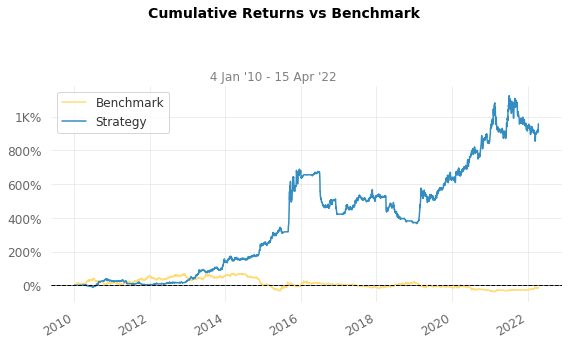

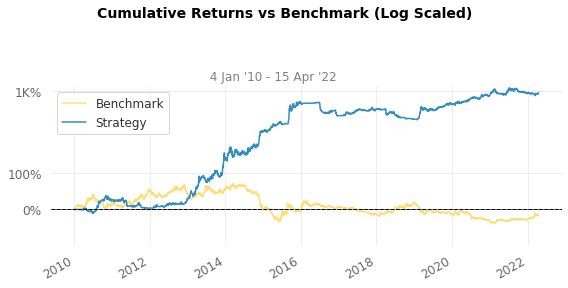

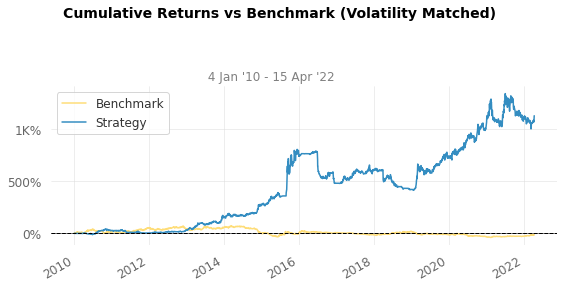

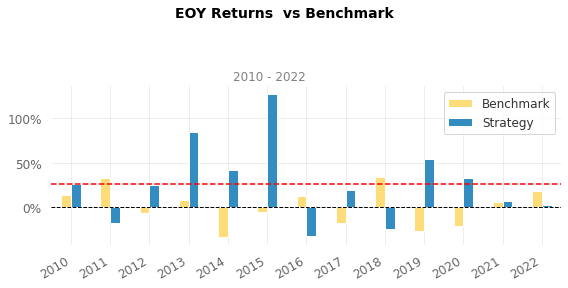

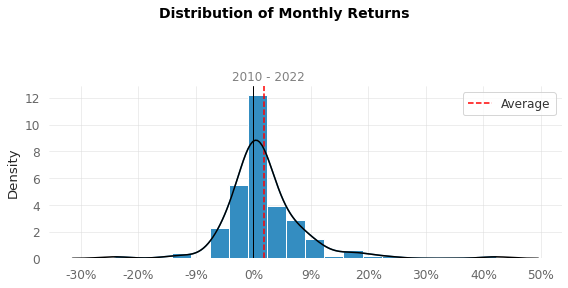

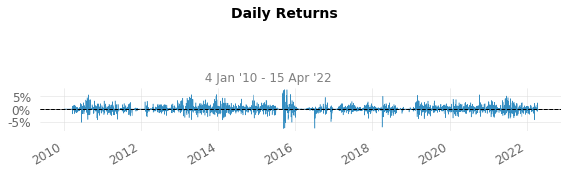

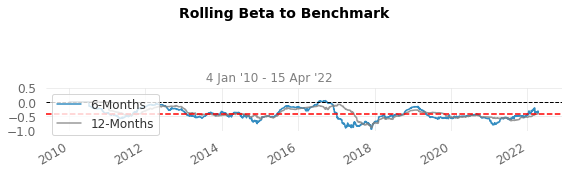

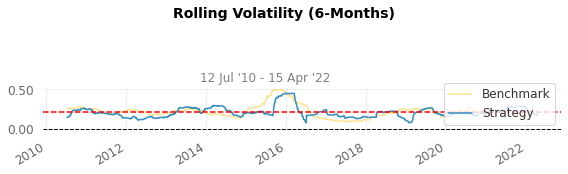

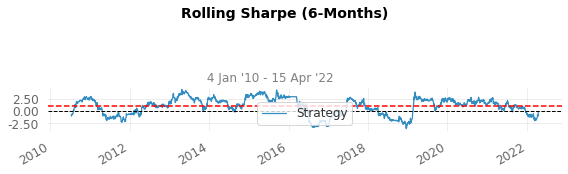

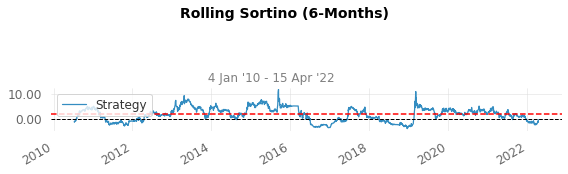

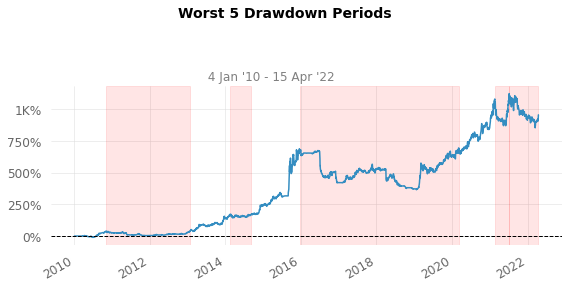

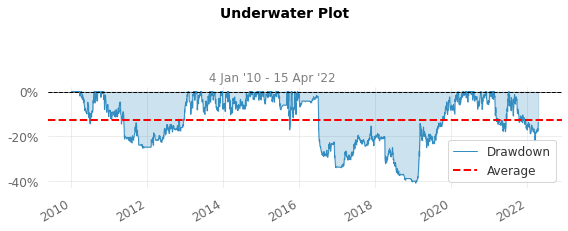

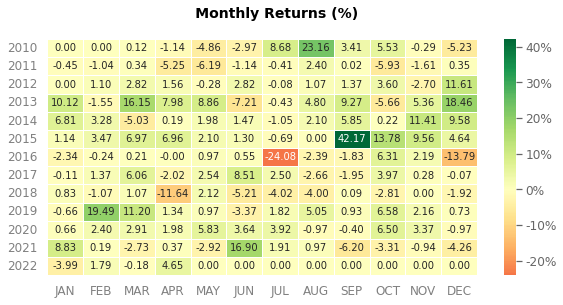

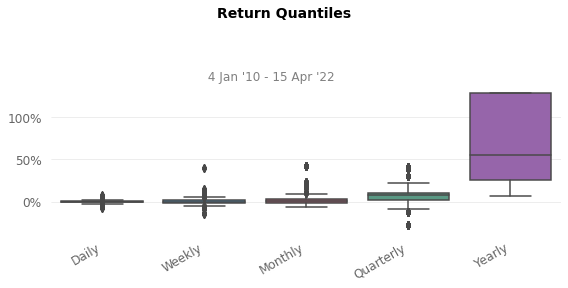

In [12]:
import akshare as ak

idx_data = ak.index_zh_a_hist(symbol='000300', period="daily", start_date='20100101', end_date='20220415')   
print(idx_data)
idx_data.rename(columns={'日期':'date', '开盘':'open', '收盘':'close', 
                           '最高':'high', '最低':'low', '成交量':'volume',
                           '成交额':'amount', '振幅':'swing', '涨跌幅':'chg_pct',
                           '涨跌额':'chg_amount', '换手率':'turnover',
                          }, inplace = True)
idx_data['date'] = pd.to_datetime(idx_data['date'], format='%Y-%m-%d')
bench=idx_data.set_index('date')
backtest.analysis(returns,bench)